In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import imghdr

2023-08-22 09:40:20.154995: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-22 09:40:20.675797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 09:40:22.628951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

2023-08-22 09:40:28.926067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 09:40:29.189319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 09:40:29.189382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Verify all the images are good

In [4]:
dataset_dir=['seg_train','seg_test']
extns=['jpeg','jpg','bmp','png']
bad_dir='bad images'
# Make directory to store bad images
try:
    os.mkdir(bad_dir)
except FileExistsError:
    None
# Iterate through the given directories
for set in dataset_dir:
    for image_class in os.listdir(set):
        for image in os.listdir(os.path.join(set,image_class)):
            image_path=os.path.join(set,image_class,image)
            try:
                img=cv2.imread(image_path) # Check if images load in cv2
                tip=imghdr.what(image_path).lower() # Check if images have acceptable extensions
                if tip not in extns:
                    print(f'Invalid exts: {image_path}')
                    os.rename(image_path,os.path.join(bad_dir,image)) # Move bad images to bad_dir
            except: # Exception handling for cv2 failure
                print(f'Issue with: {image_path}')
                os.rename(image_path,os.path.join(bad_dir,image)) 

# Loading data and normalising 

In [5]:
# Set batch size and load data from test and train directories
batch_size=16 #4GB VRAM experience
x_train=tf.keras.utils.image_dataset_from_directory('seg_train',image_size=(150,150),batch_size=batch_size)
x_test=tf.keras.utils.image_dataset_from_directory('seg_test',image_size=(150,150),batch_size=batch_size)

Found 8005 files belonging to 2 classes.


2023-08-22 09:42:55.592103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 09:42:55.592192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 09:42:55.592213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 09:42:57.021881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-22 09:42:57.021959: I tensorflow/compile

Found 2023 files belonging to 2 classes.


### Create a numpy iterator to show a sample of x_train

In [6]:
x_train_iterator=x_train.as_numpy_iterator()
train_batch=x_train_iterator.next()

### Showing a sample of the data

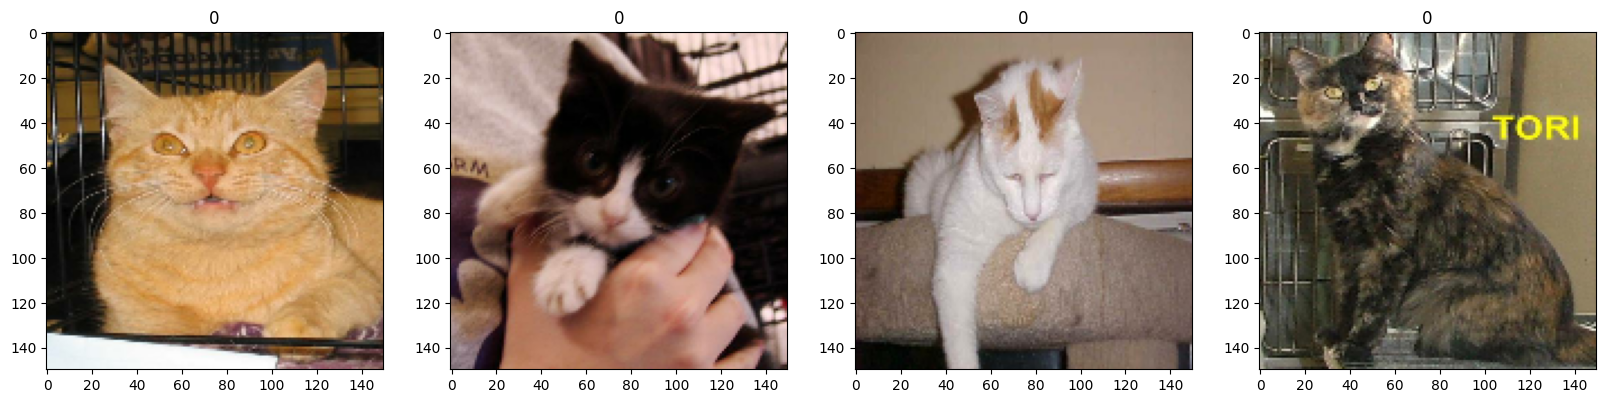

In [7]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(train_batch[1][idx])

### Normailising x_train and x_test

In [8]:
x_train=x_train.map(lambda x,y: (x/255,y))
x_test=x_test.map(lambda x,y: (x/255,y))

### Define test and train

In [9]:
train,test=x_train,x_test

# Creating and Compiling the model

In [11]:
# Import model layers 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
# Define model as sequential
model = Sequential()
model.add(Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Flatten())
model.add(Dense(180,activation='relu'))
model.add(Dense(150,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [12]:
# Compile module
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Show module summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 200)     5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 180)       0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 180)       291780    
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 140)       226940    
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 100)       126100    
                                                        

In [14]:
logdir='logs'
epochs=10
tensorboard_callback=keras.callbacks.TensorBoard(log_dir=logdir)
hist=model.fit(train,epochs=epochs,validation_data=test,callbacks=[tensorboard_callback]) #Train the model

Epoch 1/10
501/501 [==============================] - 251s 501ms/step - loss: nan - accuracy: 0.4997 - val_loss: nan - val_accuracy: 0.4998
Epoch 2/10
362/501 [====================>.........] - ETA: 1:22 - loss: nan - accuracy: 0.5014

# Plotting the Loss and Accuracy 

In [ ]:
# Loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Calculate predictions

In [ ]:
dir='seg_pred'
yhat=[]
# Predict each image
for img_name in os.listdir(dir):
    img=cv2.imread(os.path.join(dir,img_name))
    resized=tf.image.resize(img,(150,150))
    yhat.append(model.predict(np.expand_dims(resized/255,0)))
preds=[]
# Get max prediction for each image
for i in yhat:
    preds.append(np.argmax(i.reshape(6)))
preds=np.array(preds)
# Save predictions to 'preds.txt'
with open('preds.txt','a') as fl:
    for pred in preds:
        fl.write(f"{pred}\n")

# Test

In [ ]:
# Show single image
class_names=['dog']
i=0
index=preds[i]
img=cv2.imread(os.path.join(dir,os.listdir(dir)[i]))
plt.figure()
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('Image #{} : '.format(i) + class_names[index])
plt.show()